In [1]:
# %load ising_parallel.py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import multiprocessing
from functools import partial
import random
import pandas as pd

plt.rcParams['figure.figsize'] = [11, 6]  # for larger pictures

np.random.seed(0)

def energy(a, B, J=1):
    interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
    current_energy = (-J * interactions + B) * a
    return current_energy

def half_iteration(a, B, mask, J = 1, beta = 1):
    deltaE = -2 * energy(a, B, J)
    boltzmann = np.exp(-beta * deltaE) * mask
    flip_these = np.random.random(a.shape) < boltzmann
    a[flip_these] *= -1

# make a checkerboard pattern to preserve causality, updating spins on alternating diagonals in each iteration
def mask(a):
    a_mask = np.ones_like(a)
    a_mask[::2, ::2] = 0
    a_mask[1::2, 1::2] = 0
    return a_mask

def full_iteration(a, B, mask, J = 1, beta = 1):
        # this now becomes a VERY thin wrapper!
    for i in range(2):
        if random.randint(0, 1):
            half_iteration(a, B, mask, J, beta)
        else:
            half_iteration(a, B, 1-mask, J, beta)


def full_correlated_iteration(a, B, mask, J = 1, beta = 1):
    half_iteration(a, B, mask, J, beta)
    half_iteration(a, B, 1-mask, J, beta)
            
def magnetization(a):
#     interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
#     mod_a = np.abs(a)
    return a.mean()

def internal_energy(a, B, J = 1):
    current_energy = energy(a, B, J)
    return current_energy.mean()

def actually_run_single_simulation()

Onsager_critical_temperature = 2 / np.log(1 + 2**0.5)  # a theoretical value
def run_single_simulation(T, iterations, size, A, B, k_b, a_mask,
                          initial_iterations, n_tries):
    beta = 1 / (k_b * T)
    
    energies = []
    energy_variances = []
    magnetizations = []
    susceptibilities = []
    
    for n in range(n_tries):
        if isinstance(A, float) or isinstance(A, int):
            a = A*np.ones(size)
        elif A == "random":
            a = np.random.randint(0, 2, size) - 1
        elif isinstance(A, np.ndarray):
            a = A.copy()
        else:
            raise(ValueError)

        M = []
        Mnoabs = []
        E = []
        for i in range(initial_iterations):
            full_iteration(a, B, a_mask, beta=beta)

        for i in range(iterations):
            E.append(internal_energy(a, B))
            m = a.mean()
            M.append(m)
            full_iteration(a, B, a_mask, beta=beta)
        
        energies.append(np.mean(E))
        energy_variances.append(np.var(E) * beta / T * size[0]**2)
        magnetizations.append(np.mean(np.abs(M)))
        susceptibilities.append(np.var(Mnoabs) * beta * size[0]**2)
        
    return (np.mean(energies), np.std(energies)), (np.mean(energy_variances), np.std(energy_variances)), (np.mean(magnetizations), np.std(magnetizations)), (np.mean(susceptibilities), np.std(susceptibilities))
    

def simulation(iterations=5000,
               size=(64,64),
               A = 1,
               B = None,
               initial_iterations=500,
               T_range = np.linspace(1e-6, 8),
               k_b=1,
               plotting=True,
               show_samples=False,
               n_tries=10,
               n_procs = None):
    energies = []
    magnetizations = []
    As = []
    a_mask = np.ones(size)
    a_mask[::2, ::2] = 0
    a_mask[1::2, 1::2] = 0
    if B is None:
        B = np.zeros(size)
    
    parallelizable_function = partial(run_single_simulation, iterations=iterations, initial_iterations=initial_iterations, size=size, A = A, B=B, k_b=k_b, a_mask=a_mask, n_tries=n_tries)
    
    if n_procs is not None:
        with multiprocessing.Pool(n_procs) as p:
            results = list(tqdm(p.imap(parallelizable_function, T_range), total=len(T_range)))
    else:
        results = list(tqdm(map(parallelizable_function, T_range), total=len(T_range)))
    
    energies, energy_variances, magnetizations, susceptibilities = zip(*results)
    E, dE = np.vstack(energies).T
    stdE, dstdE = np.vstack(energy_variances).T
    M, dM = np.vstack(magnetizations).T
    susceptibilities, dsusceptibilities = np.vstack(susceptibilities).T

    maximum_index = np.argmax(stdE)
    our_critical_temperature = T_range[maximum_index]
    df = pd.DataFrame(data={'Temperature':T_range, 'E':E, 'dE':dE, 'M':M, 'dM':dM, 'Cv':stdE, 'dCv':dstdE, 'susceptibility': susceptibilities, 'dsusceptibility':dsusceptibilities})
    df.to_csv("ising_wyniki.csv")
    if plotting:
        plot(df)

def plot(df, lineformat="o--", show=False):
    fig, axes = plt.subplots(2, 2, sharex=True)
    axes[0,0].errorbar(df.Temperature, df.E, df.dE, fmt=lineformat)
    axes[0,0].set_ylabel("Average energy per spin")
    axes[0,0].set_xlim(df.Temperature.min(), df.Temperature.max());
    axes[0,0].axvline(Onsager_critical_temperature, color='black')

    axes[0,1].errorbar(df.Temperature, df.M, df.dM, fmt=lineformat)
    axes[0,1].set_ylabel("Average magnetization")
    axes[0,1].set_xlim(df.Temperature.min(), df.Temperature.max());
    axes[0,1].axvline(Onsager_critical_temperature, color='black')

    axes[1,0].errorbar(df.Temperature, df.Cv, df.dCv, fmt=lineformat)
    axes[1,0].set_xlabel(r"Temperature [in units where $k_B = 1$]")
    axes[1,0].set_ylabel("Heat capacity per spin")
    axes[1,0].set_xlim(df.Temperature.min(), df.Temperature.max());
    axes[1,0].axvline(Onsager_critical_temperature, color='black')
    
    axes[1,1].errorbar(df.Temperature, df.susceptibility, df.dsusceptibility, fmt=lineformat)
    axes[1,1].set_xlabel(r"Temperature [in units where $k_B = 1$]")
    axes[1,1].set_ylabel("Magnetic susceptibility")
    axes[1,1].set_xlim(df.Temperature.min(), df.Temperature.max());
    axes[1,1].axvline(Onsager_critical_temperature, color='black')
    plt.tight_layout()
    fig.savefig("ising_wyniki.pdf")
    if show:
        plt.show()
    else:
        plt.close()

#simulation(iterations=500, initial_iterations=500, size=(6,6), T_range=np.array([5, 4, 3, 2, 1]), B=0)
simulation( B=0, n_procs=4, T_range = np.linspace(1, 3.5, 100))
# plot(pd.read_csv("ising_wyniki.csv"), show=True)


In [16]:
%debug

> <ipython-input-15-cd36f3b0352d>(53)analysis()
     51 
     52 def analysis(T_range, E, dE, M, dM, size, k_B=1, plotting=True):
---> 53     Cv = dE**2 / k_B / T_range**2  # see Fitzpatrick
     54     susceptibility = dM
     55     maximum_index = np.argmax(Cv)



ipdb>  dE


((1.9554474430179707, 0.016931344621382738), (1.965882750112036, 0.02325399151140664), (1.9489904038989916, 0.01351268723626414), (0.9714129969177957, 0.04731769278747512), (0.013673557470748592, 0.007825839001646321))


ipdb>  p M


((0.22754444444444447, 0.014575512188446604), (0.2831777777777778, 0.015908472779397765), (0.4479222222222222, 0.02818002313170988), (0.9202444444444445, 0.012920726960399146), (0.9994555555555558, 0.00030812054719695116))


ipdb>  exit


E         M            Cv  susceptibility
0.000001 -4.000000  1.000000  0.000000e+00    0.000000e+00
0.163266 -4.000000  1.000000  0.000000e+00    0.000000e+00
0.326532 -4.000000  1.000000  0.000000e+00    0.000000e+00
0.489797 -3.999999  1.000000  3.254008e-09    3.986825e-07
0.653062 -3.999936  0.999992  1.144317e-05    2.711242e-05
0.816327 -3.999077  0.999884  1.408404e-03    2.993839e-04
0.979593 -3.995253  0.999394  1.599265e-02    1.341142e-03
1.142858 -3.984087  0.997938  5.496092e-02    4.124483e-03
1.306123 -3.959268  0.994607  1.116822e-01    1.064294e-02
1.469389 -3.913945  0.988191  1.844641e-01    2.339593e-02
1.632654 -3.838952  0.976969  2.720974e-01    4.809959e-02
1.795919 -3.724807  0.958087  3.672644e-01    1.093335e-01
1.959184 -3.547502  0.923642  4.729260e-01    2.687967e-01
2.122450 -3.279221  0.856953  5.777592e-01    8.268280e-01
2.285715 -2.773811  0.474758  6.759871e-01    2.778592e+02
2.448980 -2.308658  0.119447  6.636601e-01    3.601896e+01
2.612246 -2.042134  0.075055  6.059204e-01    1.428531e+01
2.775511 -1.842537  0.056145  5.448944e-01    7.172086e+00
2.938776 -1.685659  0.042486  4.896055e-01    4.130921e+00
3.102041 -1.556658  0.038628  4.401456e-01    3.036202e+00
3.265307 -1.451329  0.033798  3.971908e-01    2.200463e+00
3.428572 -1.355165  0.032940  3.598072e-01    1.992119e+00
3.591837 -1.278192  0.030334  3.274803e-01    1.650750e+00
3.755103 -1.206878  0.027838  2.987854e-01    1.307488e+00
3.918368 -1.143958  0.026004  2.734976e-01    1.117557e+00
4.081633 -1.086777  0.024392  2.515109e-01    9.424217e-01
4.244898 -1.036888  0.023870  2.319394e-01    8.655243e-01
4.408164 -0.992015  0.024174  2.145684e-01    8.517545e-01
4.571429 -0.949706  0.022103  1.989591e-01    6.931116e-01
4.734694 -0.911425  0.021953  1.849768e-01    6.474297e-01
4.897960 -0.875685  0.021109  1.725606e-01    5.888459e-01
5.061225 -0.843769  0.020746  1.614946e-01    5.414081e-01
5.224490 -0.813500  0.020979  1.511310e-01    5.372653e-01
5.387755 -0.787009  0.019787  1.418229e-01    4.672883e-01
5.551021 -0.760303  0.019790  1.334195e-01    4.529085e-01
5.714286 -0.737494  0.019430  1.257282e-01    4.251742e-01
5.877551 -0.714317  0.019102  1.186780e-01    4.012008e-01
6.040817 -0.694681  0.018717  1.124304e-01    3.732648e-01
6.204082 -0.673448  0.018719  1.064213e-01    3.584038e-01
6.367347 -0.655906  0.019073  1.008524e-01    3.673813e-01
6.530612 -0.636861  0.018042  9.582723e-02    3.204251e-01
6.693878 -0.620540  0.018370  9.100675e-02    3.224432e-01
6.857143 -0.604672  0.018065  8.669451e-02    3.083009e-01
7.020408 -0.588744  0.016940  8.264168e-02    2.654013e-01
7.183674 -0.576121  0.017067  7.882891e-02    2.628713e-01
7.346939 -0.562619  0.017097  7.540278e-02    2.647904e-01
7.510204 -0.547434  0.017128  7.210992e-02    2.536277e-01
7.673469 -0.536681  0.016673  6.899765e-02    2.351803e-01
7.836735 -0.525013  0.016919  6.615853e-02    2.371419e-01
8.000000 -0.513129  0.016911  6.341255e-02    2.285676e-01

2.285715

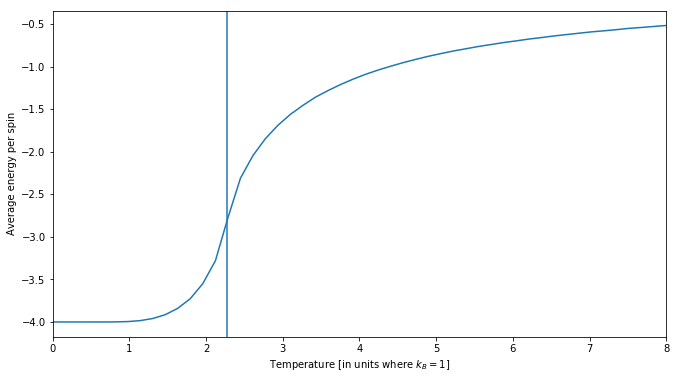

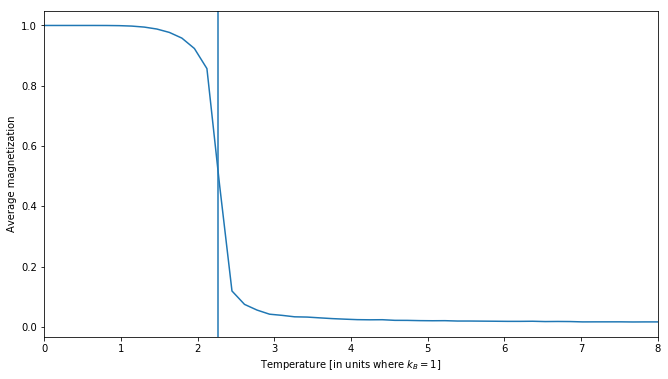

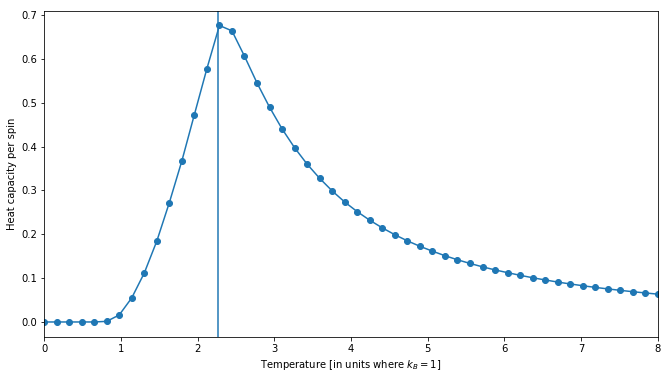

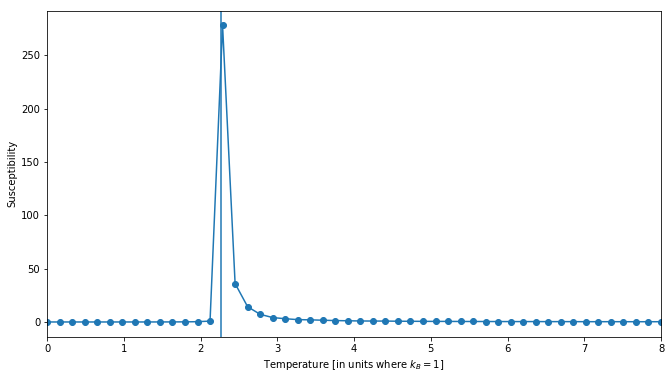

In [139]:
simulation(B=0)

E         M        Cv  susceptibility
0.000001 -3.000000  1.000000  0.000000        0.000000
0.163266 -3.000000  1.000000  0.000000        0.000000
0.326532 -3.000000  1.000000  0.000000        0.000000
0.489797 -2.999918  0.999988  0.000030        0.000049
0.653062 -4.509249  0.985095  0.004473     4481.609229
0.816327 -4.999907  0.999990  0.000019        0.000026
0.979593 -4.999303  0.999922  0.000675        0.000159
1.142858 -4.997077  0.999673  0.006642        0.000588
1.306123 -4.991284  0.999023  0.025954        0.001574
1.469389 -4.979374  0.997673  0.056770        0.003445
1.632654 -4.957867  0.995205  0.097107        0.006640
1.795919 -4.923991  0.991262  0.145174        0.011546
1.959184 -4.875494  0.985498  0.198500        0.017640
2.122450 -4.810501  0.977607  0.253880        0.027798
2.285715 -4.725707  0.967014  0.310833        0.039432
2.448980 -4.622069  0.953717  0.364556        0.054509
2.612246 -4.495670  0.936940  0.415402        0.074032
2.775511 -4.352137  0.917209  0.457321        0.094641
2.938776 -4.190454  0.894203  0.491199        0.118875
3.102041 -4.010343  0.867464  0.516429        0.149759
3.265307 -3.812641  0.836930  0.533185        0.179955
3.428572 -3.613990  0.804985  0.537197        0.218012
3.591837 -3.411631  0.771285  0.532577        0.232447
3.755103 -3.205946  0.735103  0.520238        0.279043
3.918368 -3.009012  0.699228  0.501554        0.300264
4.081633 -2.813947  0.662484  0.479197        0.315605
4.244898 -2.632093  0.627169  0.453766        0.360023
4.408164 -2.462002  0.592486  0.426612        0.365926
4.571429 -2.307827  0.560379  0.399425        0.356515
4.734694 -2.165125  0.529961  0.372845        0.350077
4.897960 -2.031916  0.500755  0.347352        0.344158
5.061225 -1.912294  0.474130  0.323246        0.354206
5.224490 -1.804954  0.449685  0.300827        0.343595
5.387755 -1.705809  0.426118  0.280017        0.328713
5.551021 -1.614280  0.404795  0.260853        0.329667
5.714286 -1.529618  0.384019  0.243132        0.331496
5.877551 -1.453041  0.365525  0.226890        0.320786
6.040817 -1.385974  0.348885  0.212214        0.319596
6.204082 -1.322849  0.333286  0.198707        0.300249
6.367347 -1.265036  0.318754  0.186416        0.281562
6.530612 -1.211563  0.304922  0.175014        0.274410
6.693878 -1.162386  0.291929  0.164630        0.264832
6.857143 -1.117961  0.280812  0.155280        0.256422
7.020408 -1.076833  0.270319  0.146566        0.242967
7.183674 -1.036869  0.259692  0.138493        0.235001
7.346939 -1.001365  0.250352  0.131055        0.237394
7.510204 -0.967044  0.241929  0.124282        0.230499
7.673469 -0.934455  0.232971  0.117909        0.229993
7.836735 -0.907577  0.226167  0.112141        0.215989
8.000000 -0.879381  0.218362  0.106649        0.196179

3.4285720000000004

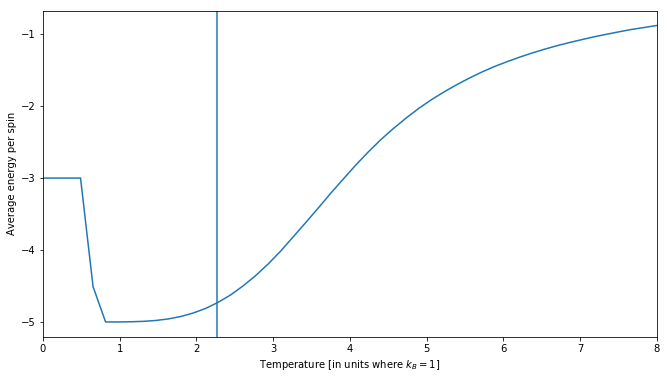

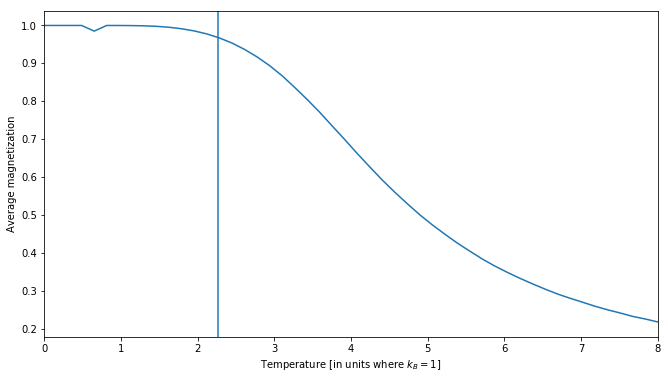

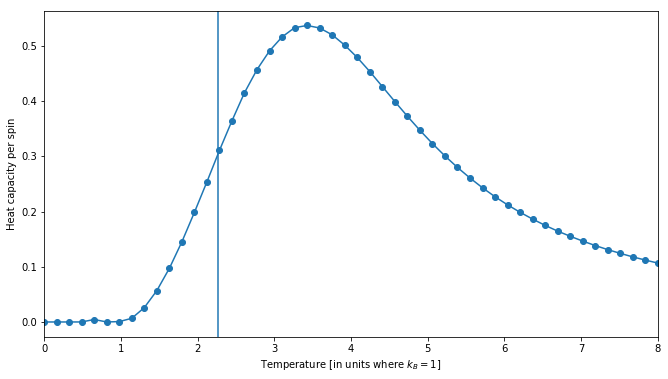

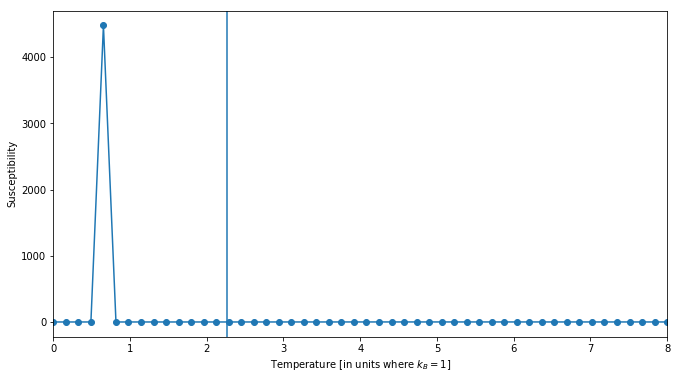

In [140]:
simulation(B=1)